# Deep Learning Project 6 - Fake News Prediction :
---
- ### Write a program that takes in data on news stories as input and uses deep learning algorithms to predict whether or not a news story is likely to be fake.

- ### Your task is to choose an appropriate deep learning algorithm for predicting fake news based on available data. You can use metrics such as accuracy, precision, recall, or F1 score to evaluate the performance of your model.

- ### To make sure your code is readable, you should add comments wherever necessary for proper understanding.
---
# Importing necessary libraries :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import gc

In [2]:
!pip install keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00


In [29]:
from keras.models import Model, Sequential
# Importing Tokenizer from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Flatten, Dense, Embedding, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.python.client import device_lib
from transformers import AutoTokenizer, TFBertModel

# Loading the dataset :

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data_Science/Projects/Deep Learning Projects/Datasets/WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


# Checking details of dataframe 'df' :

In [5]:
df.shape

(72134, 4)

In [6]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


# Checking missing values :

In [8]:
df.isnull().sum()

,0
Unnamed: 0,0
title,558
text,39
label,0


## Removing column - 'Unnamed: 0' :

In [9]:
df = df.drop('Unnamed: 0', axis = 1)

# Removing rows from the DataFrame df where either the 'text' or 'title' column has missing values :

In [10]:
df.dropna(subset = ['text', 'title'], inplace = True)

## Combining the 'title' and 'text' columns, separated by a space, and stores the result in the 'text' column :

In [11]:
df['text'] = df['title'] + ' ' + df['text']

## Below lines extract the 'text' and 'label' columns from the DataFrame df and assign them to variables x and y, respectively, for further processing :

In [12]:
x = df['text']
y = df['label']

# Importing modules for basic NLP operations :

In [13]:
import spacy  # it's a NLP processing model
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk
import time

## Below lines download and prepare necessary resources for preprocessing text data, specifically for removing stop words and splitting text into tokens using **NLTK** and **spaCy**.

In [14]:
nltk.download('stopwords')

stopwords_set = set(stopwords.words('english'))

nlp = English()
spacy_tokenizer = nlp.tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Below **'optimized_preprocessing'** tokenizes text, removes stop words and punctuation, converts to lowercase, and returns the joined tokens.

In [15]:
def optimized_preprocessing(texts) :
  result = []

  for text in texts :
    tokens = [token.text.lower() for token in spacy_tokenizer(text) if token.text.isalpha()
              and token.text.lower() not in stopwords_set]
    result.append(" ".join(tokens))

  return result

## Measuring and printing the time taken to execute the **optimized_preprocessing** function on the **'text'** column of the DataFrame **df** :

In [16]:
# Getting the current time and storing it in the variable 's'. This marks the starting point for measuring the
# execution time.
s = time.time()

# Applying the 'optimized_preprocessing' function to the 'text' column of the DataFrame 'df'.
# This processes the text data (tokenization, stop word removal, etc.) and stores the results in a new column
# called 'Full_text_cleaned'.
df['Full_text_cleaned'] = optimized_preprocessing(df.text)

# Calculating the time taken to execute the preprocessing step by subtracting the start time ('s') from the
# current time. The result is stored in the variable 'time_to_clean'.
time_to_clean = time.time() - s

# Printing the time taken to clean the data.
# The {:.2f} format specifier is used to display the time with two decimal places.
print('Time to clean {:.2f}'.format(time_to_clean))

Time to clean 203.90


## Below as we can see the column 'Full_text_cleaned' has both 'title' and the 'text' which is cleaned and all the stopwords have been removed.

In [17]:
df.head()

,title,text,label,Full_text_cleaned
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,law enforcement high alert following threats c...
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,unbelievable obama attorney general says charl...
3,"Bobby Jindal, raised Hindu, uses story of Chri...","Bobby Jindal, raised Hindu, uses story of Chri...",0,bobby jindal raised hindu uses story christian...
4,SATAN 2: Russia unvelis an image of its terrif...,SATAN 2: Russia unvelis an image of its terrif...,1,satan russia unvelis image terrifying new supe...
5,About Time! Christian Group Sues Amazon and SP...,About Time! Christian Group Sues Amazon and SP...,1,time christian group sues amazon splc designat...


# Defining feature and target :

In [18]:
x = df['Full_text_cleaned']
y = df['label']

# Splitting our dataset into training and testing data :

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

## **Let's break below line of code down :**
- ### **tokenizer = Tokenizer(...) :** This line creates an instance of the **Tokenizer** class from the **tensorflow.keras.preprocessing.text** module and assigns it to the variable tokenizer. The Tokenizer class is used to convert text data into numerical sequences that can be fed into a neural network.
- ### **num_words = 10000 :** This argument specifies the maximum number of words to keep in the vocabulary. The tokenizer will only consider the top 10,000 most frequent words in our dataset.
- ### **oov_token = '<00v>' :** This argument defines a special token to represent words that are not in the vocabulary (out-of-vocabulary words). In this case, any word not within the top 10,000 most frequent words will be replaced with the token <00v>.

## **Reasoning :**

- ### **Vocabulary Limitation :** By setting **num_words**, we are limiting the size of our vocabulary. This helps to reduce the dimensionality of our data and can improve the efficiency of our model.
- ### **Handling Out-of-Vocabulary Words :** Using an **oov_token** ensures that our model can still handle words it has never seen before during training. Instead of ignoring unknown words, they are replaced with a special token, allowing the model to learn some information about them.
### **In essence, this line of code initializes a tokenizer that will convert our text data into numerical sequences, using a vocabulary of the 10,000 most frequent words and a special token for unknown words.**

In [20]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<00v>')

In [21]:
print(tokenizer)

## **tokenizer.fit_on_texts** creates vocabulary from **x_train** and **word_index** stores it as {word:index}.

In [22]:
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [23]:
print(len(word_index))

191263


## **sequences = tokenizer.texts_to_sequences(x) :** converts the text in **x** to sequences of numerical tokens using the vocabulary built by the tokenizer

In [24]:
sequences = tokenizer.texts_to_sequences(x)

## Below code creates a list called **lengths_of_texts** storing the length of each sequence (numerical representation of text) within the **sequences** list.

In [25]:
lengths_of_texts = [len(text) for text in sequences]
print(lengths_of_texts)

[447, 35, 743, 192, 151, 19, 10, 154, 279, 399, 232, 266, 32, 297, 166, 316, 90, 668, 251, 132, 265, 191, 1450, 220, 125, 325, 513, 520, 277, 56, 818, 175, 443, 575, 240, 20, 770, 272, 202, 652, 484, 308, 254, 107, 1481, 350, 422, 612, 646, 547, 657, 618, 264, 437, 226, 769, 89, 208, 199, 112, 484, 266, 296, 114, 233, 305, 614, 162, 226, 417, 271, 67, 283, 284, 127, 863, 45, 10, 229, 1221, 189, 705, 155, 354, 276, 240, 354, 543, 136, 699, 196, 146, 216, 179, 215, 137, 126, 589, 37, 691, 266, 36, 716, 120, 9, 290, 23, 466, 280, 251, 305, 268, 2870, 388, 185, 220, 160, 255, 501, 1006, 110, 542, 381, 1259, 158, 503, 29, 255, 316, 768, 266, 300, 206, 140, 180, 244, 276, 76, 277, 472, 208, 276, 937, 747, 439, 697, 206, 515, 662, 83, 134, 2947, 170, 274, 208, 159, 384, 174, 126, 414, 155, 379, 515, 88, 351, 526, 653, 305, 184, 166, 491, 205, 254, 208, 202, 278, 313, 139, 895, 56, 221, 514, 212, 1340, 3932, 584, 329, 211, 545, 134, 558, 281, 58, 239, 49, 224, 99, 719, 54, 30, 265, 52, 164, 92

In [26]:
print(len(lengths_of_texts))

71537


## Below lines convert the text data in **x_train** and **x_test** into numerical sequences using the tokenizer's vocabulary.

In [28]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

## Below lines of code pads/truncates text sequences in **x_train** and **x_test** to the average length **(avg_len_texts)** for consistent input to the model.

In [30]:
avg_len_texts = int(np.mean(lengths_of_texts))
x_train_pad = pad_sequences(x_train, maxlen = avg_len_texts, padding = 'post', truncating = 'post')
x_test_pad = pad_sequences(x_test, maxlen = avg_len_texts, padding = 'post', truncating = 'post')

## Checking the shape :

In [31]:
x_train_pad.shape

(57229, 310)

In [32]:
x_test_pad.shape

(14308, 310)

## Below code defines a sequential model with an embedding layer, a flatten layer, two dense layers, and a batch normalization layer for fake news prediction.

In [33]:
model = Sequential([
    Embedding(input_dim = len(word_index), output_dim = 16, input_length = avg_len_texts),
    Flatten(),
    Dense(16, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Below code compiles the model for training using the Adam optimizer, binary cross-entropy loss, and accuracy metric.

In [34]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Below code stops training when val_loss doesn't improve for 20 epochs, preventing overfitting.

In [35]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 20)

## Below code trains the model using training data, validates with test data, and may stop early to prevent overfitting.

In [36]:
history = model.fit(x_train_pad, y_train, epochs = 100, batch_size = 200,
                    validation_data = (x_test_pad, y_test), callbacks = [early_stop])

Epoch 1/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.8425 - loss: 0.3195 - val_accuracy: 0.9593 - val_loss: 0.1788
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9897 - loss: 0.0356 - val_accuracy: 0.9654 - val_loss: 0.0940
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9989 - loss: 0.0079 - val_accuracy: 0.9632 - val_loss: 0.1157
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.9998 - loss: 0.0027 - val_accuracy: 0.9658 - val_loss: 0.1173
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 1.0000 - loss: 8.0332e-04 - val_accuracy: 0.9652 - val_loss: 0.1325
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9637 - val_loss: 0.1375
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9635 - val_loss: 0.1465
Epoch 8/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 1.0000 - los

## Below code plots training and validation accuracies over epochs to visualize model performance.

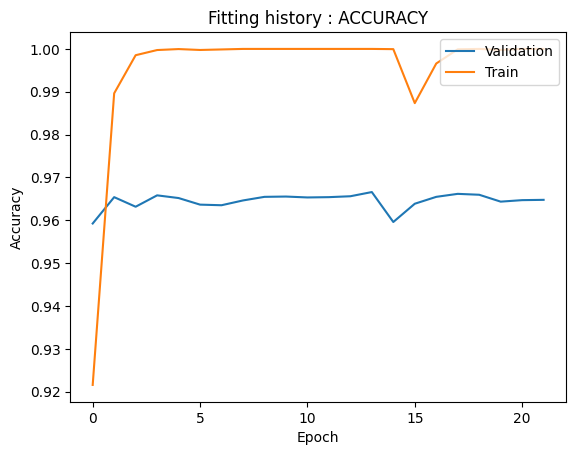

In [37]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Fitting history : ACCURACY')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')

plt.show()